# Use Case 6: Combining Ambiguity Statistics with Semantic Selection (N1904addons)

## Table of content (ToC)<a class="anchor" id="TOC"></a>
* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Load N1904-TF with the N1904addons</a>
* <a href="#bullet3">3 - Analyses</a>
    * <a href="#bullet3x1">3.1 - Create an object-subject-verb relation dictionary</a>
    * <a href="#bullet3x2">3.2 - Make a selection using semantic role labeling</a>
    * <a href="#bullet3x3">3.3 - Create a further selection</a>
    * <a href="#bullet3x4">3.4 - Now examine the extent of alternative interpretations</a>
    * <a href="#bullet3x5">3.5 - Create some plots</a>
    * <a href="#bullet3x6">3.6 - Performing some cross checks</a>
* <a href="#bullet4">4 - Attribution and footnotes</a>
* <a href="#bullet5">5 - Required libraries</a>
* <a href="#bullet6">6 - Notebook version</a>


#  1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

This Jupyter Notebook documents and demonstrates how the N1904addons integrate with the richly annotated base N1904 TF dataset. All features introduced by this extension are fully compatible with the existing feature set, enabling fine-grained, cross-sectional analysis. In this use case, we investigate potential case alternations in subjects and objects governed by verbs in the indicative mood, aorist tense, and active voice.

# 2 - Load N1904-TF with the N1904addons <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

Since the new feature should act as an extention to the N1904-TF dataset, we first need to load this dataset, together with the Text-Fabric Python code.
We need the full N1904addons dataset.

In [1]:
# Load the autoreload extension to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

In [2]:
# Loading the Text-Fabric code
from tf.fabric import Fabric
from tf.app import use

In [3]:
# Load the N1904-TF app and data with the additional features
A = use ("CenterBLC/N1904", mod=["tonyjurg/N1904addons/tf/", "tonyjurg/N1904addons/detailed_set"], silence="terse", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

In [4]:
# The following will push the Text-Fabric stylesheet to this notebook (to facilitate proper display with notebook viewer)
A.dh(A.getCss())

# 3 - Analyses <a class="anchor" id="bullet3"></a>
##### [Back to ToC](#TOC)

This is the high-level overview of this section. First, a subject–object–verb triple dictionary will be constructed using the frame edge feature, which encodes semantic role labeling (SRL) information. This dictionary maps each predicate to its associated arguments, specifically identifying subjects (A0; agent) and direct or indirect objects (A1; patient). From this set, only entries with exactly one subject and one direct object are to be retained. The resulting triples are then further filtered to include only predicates in the indicative mood, aorist tense, and active voice, where the subject is in the nominative case and the object in the accusative case. This filtering process will give use a set of triples that will be input to the further analysis.

With this curated set, all morphological-detail (md*) features are then scanned block by block. For each triple, the lemma of the predicate, subject, and object wil be compared against the corresponding lemma in each analytic block. If a match is found, the relevant grammatical features is to be extracted: for predicates, mood, voice, and tense; for subjects and objects, case. These features are then counted separately: predicate properties in one set of counters, subject cases in another, and object cases in a third.

Finally, the data will be visualized to highlight the distribution of grammatical cases among subjects and objects.

## 3.1 - Create an object-subject-verb relation dictionary <a class="anchor" id="bullet3x1"></a>

In this codeblock I utilize the edge feature <a href="https://centerblc.github.io/N1904/features/frame.html" target="_blank">`frame`</a> which contains Semantic Role Labeling. We will query to extract verbs with their associated direct or indirect objects (A1/A2) and subjects (A0). For each match the code pulls grammatical case, semantic class (Louw Nida),  tense, mood, and voice features. Then it counts them usins a compound key and stores the totals in a Counter. The last step is to transform the counter into a sorted list of tuples and prints the top entries in a formatted table showing object-case, tense, mood, voice, subject-case, and count.

In [5]:
data = dict(E.frame.items())

In [6]:
from collections import Counter

# Build a counter of nodeTypes just to make sure they only are pointing to word nodes
nodeTypes = Counter()
for key, role_map in data.items():
    nodeTypes[F.otype.v(key)]+=1
nodeTypes

Counter({'word': 25491})

This shows that data is actually using a two‐level mapping:

- Outer key `u` is the source node.

- Inner mapping is `{ v: val, … }` giving each target `v` and its feature value `val`.

So the following can be done:

## 3.2 - Make a selection using semantic role labeling <a class="anchor" id="bullet3x2"></a>

This is the data format for the Semantic Role Labeling N1904-TF edge feature <a href="https://centerblc.github.io/N1904/features/frame.html" target="_blank">'frame'</a>, as it follows Frame semantics:
                       
  - A0 = Agent or subject of the action (prototypical agent)
  - A1 = Direct object or the entity directly affected by the action (prototypical patient)
  - A2 = Indirect object or secondary entity affected by the action (prototypical recipient)
  - AA2 = Adverbial roles in a sentence

In the following codeblock I will only # keep only those cases ("u") where its targets.values() has both 'A0' and 'A1'. First with any number of both.

In [7]:
# keep only those "u" where its targets.values() has both 'A0' and 'A1'
filtered = {
    u: targets
    for u, targets in data.items()
    if 'A0' in targets.values() and 'A1' in targets.values()
}

We now want exactly two edges (one A0 and one A1), so we lest length and value‐set like this:

In [8]:
exact_pairs = {
    u: targets
    for u, targets in data.items()
    if len(targets) == 2 and set(targets.values()) == {'A0', 'A1'}
}
len(exact_pairs)

8376

Now `exact_pairs` looks like:

This code will return only the outer keys where the corresponding inner dictionary contains exactly two entries—one labeled `A0` and one labeled `A1`. However, we should be careful not to assume these roles are always in the same order. Since Python's standard unpacking does not guarantee key order, we must explicitly extract the indices associated with `A0` and `A1` from the inner dictionary.

The most reliable approach is to invert the dictionary—so that roles (`A0`, `A1`, etc.) become the keys—and then retrieve the values by role name.

That said, earlier data dumps show that roles like A1 can appear multiple times. This means we shouldn't treat role mappings as having a single value. Instead, we need to collect all indices for each role (e.g., `A0`, `A1`, `A2`) into lists.

Still, since we're currently working only with cases that match exact_pairs, we can continue with a simpler approach for now.

In [9]:
# Build a Counter of tuples
freq = Counter()

for pred, role_map in exact_pairs.items():
    # invert {index: role} → {role: index}
    inv = { role: idx for idx, role in role_map.items() }

    agent_idx   = inv['A0']   # always the A0 index
    patient_idx = inv['A1']   # always the A1 index

    s_pred    = F.sp.v(pred)          # predicate
    s_agent   = F.sp.v(agent_idx)     # A0 (prototypical agent)
    s_patient = F.sp.v(patient_idx)   # A1 (prototypical patient)

    freq[(s_pred, s_agent, s_patient)] += 1
freq.most_common(20)

[(('verb', 'subs', 'subs'), 2172),
 (('verb', 'subs', 'pron'), 1948),
 (('verb', 'subs', 'verb'), 781),
 (('verb', 'verb', 'subs'), 501),
 (('verb', 'pron', 'subs'), 416),
 (('verb', 'adjv', 'subs'), 396),
 (('verb', 'pron', 'pron'), 352),
 (('verb', 'subs', 'adjv'), 332),
 (('verb', 'verb', 'pron'), 324),
 (('verb', 'adjv', 'pron'), 291),
 (('verb', 'pron', 'verb'), 191),
 (('verb', 'adjv', 'verb'), 123),
 (('verb', 'verb', 'verb'), 116),
 (('verb', 'pron', 'adjv'), 77),
 (('verb', 'adjv', 'adjv'), 57),
 (('verb', 'verb', 'adjv'), 52),
 (('verb', 'subs', 'art'), 40),
 (('verb', 'num', 'subs'), 24),
 (('verb', 'num', 'pron'), 24),
 (('verb', 'art', 'subs'), 23)]

## 3.3 - Create a further selection <a class="anchor" id="bullet3x3"></a>

Now we can take out a subsection, e.g., (verb, subs, subs) with properties ('indicative', 'aorist', 'active', 'nominative', 'accusative') and create a list of triples.

In [10]:
# prepare an empty list to collect the triples
triples = []

for pred, role_map in exact_pairs.items():
    # invert {index: role} → {role: index}
    inv = { role: idx for idx, role in role_map.items() }

    agent_idx   = inv['A0']   # always the A0 index
    patient_idx = inv['A1']   # always the A1 index

    s_pred    = F.sp.v(pred)          # predicate pos
    m_pred    = F.mood.v(pred)        # predicate mood
    t_pred    = F.tense.v(pred)       # predicate tense
    v_pred    = F.voice.v(pred)       # predicate voice

    # A0 (prototypical agent)
    s_agent   = F.sp.v(agent_idx)     # agent pos 
    c_agent   = F.case.v(agent_idx)   # agent case

    # A1 (prototypical patient)
    s_patient = F.sp.v(patient_idx)   # patient pos
    c_patient = F.case.v(patient_idx) # patient case

    # check the labels, then store the raw pred & indices
    if s_pred == 'verb' and  m_pred=='indicative' and t_pred=='aorist' and v_pred=='active' and  s_agent == 'subs' and c_agent=='nominative'  and s_patient == 'subs' and c_patient == 'accusative' :
        triples.append((pred, agent_idx, patient_idx))

# now `triples` holds all (pred, agent_idx, patient_idx) matching our filter
print(f"Collected {len(triples)} matching triples")

Collected 340 matching triples


Now `triples` looks like:

## 3.4 - Now examine the extent of alternative interpretations <a class="anchor" id="bullet3x4"></a>

Now we generate the code to go one step deeper, as we are going to make sure the word forms are using the same lemma.

First, construct hashable lookup tables to enable direct access to the relevant grammatical features encoded in the detailed feature sets.

In [11]:
MD_BLOCK_RANGE  = range(1, 25)
md_case_feat    = {b: Fs(f"md{b}_case")         for b in MD_BLOCK_RANGE}
md_mood_feat    = {b: Fs(f"md{b}_mood")         for b in MD_BLOCK_RANGE}
md_voice_feat   = {b: Fs(f"md{b}_voice")        for b in MD_BLOCK_RANGE}
md_tense_feat   = {b: Fs(f"md{b}_tense")        for b in MD_BLOCK_RANGE}
md_lemma_feat   = {b: Fs(f"md{b}_lem_base_uc")  for b in MD_BLOCK_RANGE}

Now we can do some counting of observed combinations of grammatical properties:

In [12]:
from collections import Counter

# initialize  counters
pred_counter    = Counter()   # keys will be (mood, voice, tense)
agent_counter   = Counter()   # keys will be case labels
patient_counter = Counter()   # keys will be case labels

# iterate over the stored triples
for pred_id, agent_id, patient_id in triples:
    # look up the lemma of each node
    pred_lemma=F.lemma.v(pred_id)
    agent_lemma=F.lemma.v(agent_id)
    patient_lemma=F.lemma.v(patient_id)
    
    # scan through all MD blocks
    for b in MD_BLOCK_RANGE:
        # predicate 
        if pred_lemma==md_lemma_feat[b].v(pred_id):
            mood  = md_mood_feat[b].v(pred_id)
            voice = md_voice_feat[b].v(pred_id)
            tense = md_tense_feat[b].v(pred_id)
            pred_counter[(mood, voice, tense)] += 1
            
        # agent 
        if agent_lemma == md_lemma_feat[b].v(agent_id):
            case_agent = md_case_feat[b].v(agent_id)
            agent_counter[case_agent] += 1
            
        # patient
        if patient_lemma == md_lemma_feat[b].v(patient_id):
            case_patient = md_case_feat[b].v(patient_id)
            patient_counter[case_patient] += 1
    
# now print the counters
print("Predicate (mood, voice, tense) counts:", pred_counter)
print("Agent-case counts:", agent_counter)
print("Patient-case counts:", patient_counter)

Predicate (mood, voice, tense) counts: Counter({('indicative', 'active', 'aorist'): 361, ('infinitive', 'active', None): 20, ('participle', 'active', 'aorist'): 20, ('imperative', 'active', 'aorist'): 10, ('indicative', 'active', 'imperfect'): 6, ('infinitive', 'active', 'future'): 3, ('indicative', 'passive', 'aorist'): 3, ('infinitive', 'active', 'aorist'): 2})
Agent-case counts: Counter({'nominative': 216, 'nominative/vocative': 66, 'accusative': 62, 'dative': 25, 'nominative/vocative/accusative': 14, 'genitive': 12, None: 11})
Patient-case counts: Counter({'accusative': 241, 'nominative/vocative/accusative': 79, 'genitive': 33, 'nominative/vocative': 5, 'nominative': 5, None: 4, 'nominative/accusative': 1})


## 3.5 - Create some plots <a class="anchor" id="bullet3x5"></a>

Now let us plot the findings.

In [13]:
import matplotlib.pyplot as plt

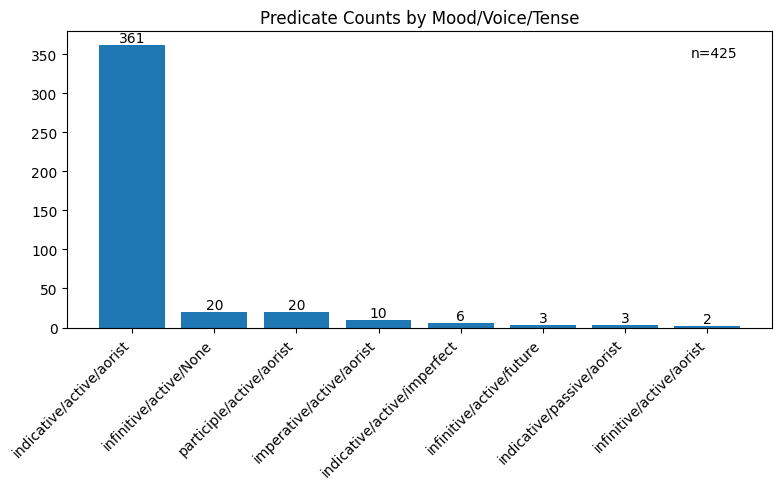

In [14]:
# Plot 1: Predicate (Mood/Voice/Tense) with counts + total n
plt.figure(figsize=(8,5))
labels_p, values_p = zip(*sorted(pred_counter.items(), key=lambda x: x[1], reverse=True))
bars = plt.bar(range(len(values_p)), values_p)
plt.xticks(range(len(labels_p)), [f"{m}/{v}/{t}" for m,v,t in labels_p],
           rotation=45, ha='right')
plt.title("Predicate Counts by Mood/Voice/Tense")

# add per‑bar labels
y_offset = max(values_p) * 0.0
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + y_offset,
             str(int(h)), ha='center', va='bottom')

# add total in top right
total_p = sum(values_p)
ax = plt.gca()
ax.text(0.95, 0.95, f"n={total_p}", transform=ax.transAxes,
        ha='right', va='top')

plt.tight_layout()
plt.show()


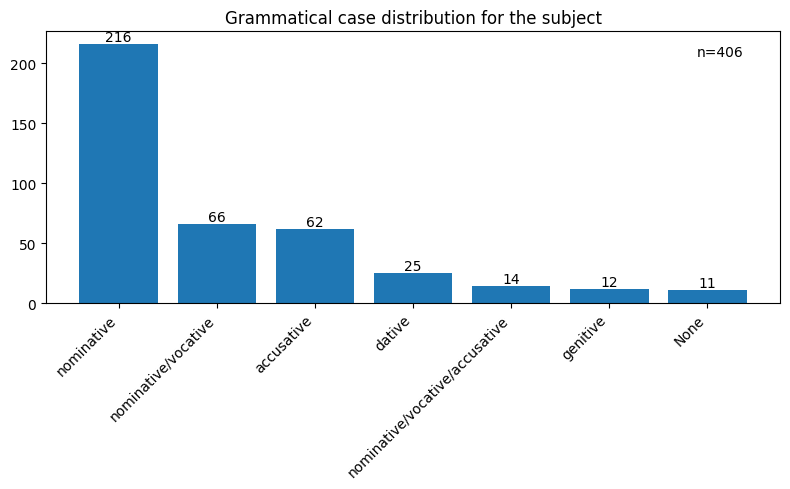

In [15]:
# Plot 2: Agent Case with counts + total n
plt.figure(figsize=(8,5))
labels_a, values_a = zip(*sorted(agent_counter.items(), key=lambda x: x[1], reverse=True))
bars = plt.bar(range(len(values_a)), values_a)
plt.xticks(range(len(labels_a)), [str(l) for l in labels_a],
           rotation=45, ha='right')
plt.title("Grammatical case distribution for the subject")

# add per‑bar labels
y_offset = max(values_a) * 0.0
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + y_offset,
             str(int(h)), ha='center', va='bottom')

# add total in top right
total_a = sum(values_a)
ax = plt.gca()
ax.text(0.95, 0.95, f"n={total_a}", transform=ax.transAxes,
        ha='right', va='top')

plt.tight_layout()
plt.show()


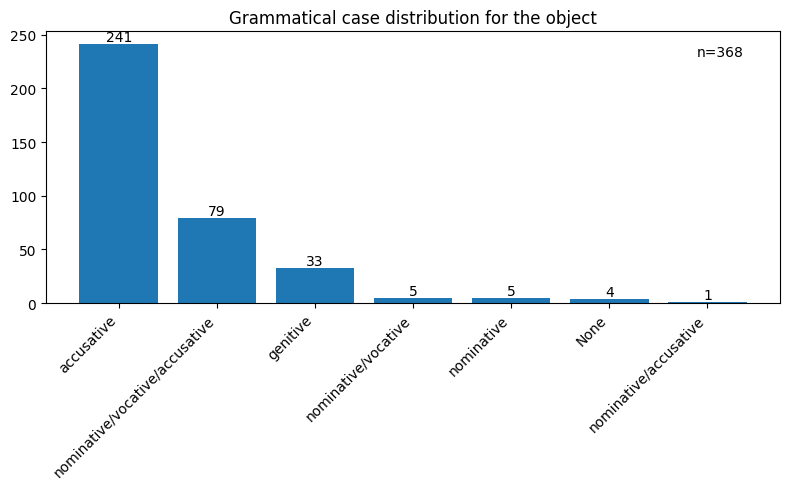

In [16]:
# Plot 3: Patient Case with counts + total n 
plt.figure(figsize=(8,5))
labels_pat, values_pat = zip(*sorted(patient_counter.items(), key=lambda x: x[1], reverse=True))
bars = plt.bar(range(len(values_pat)), values_pat)
plt.xticks(range(len(labels_pat)), [str(l) for l in labels_pat],
           rotation=45, ha='right')
plt.title("Grammatical case distribution for the object")

# add per‑bar labels
y_offset = max(values_pat) * 0.0
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + y_offset,
             str(int(h)), ha='center', va='bottom')

# add total in top right
total_pat = sum(values_pat)
ax = plt.gca()
ax.text(0.95, 0.95, f"n={total_pat}", transform=ax.transAxes,
        ha='right', va='top')

plt.tight_layout()
plt.show()



## 3.6 - Performing some cross checks <a class="anchor" id="bullet3x6"></a>

What can be noticed is that the totals seems not to add up. So this is to investigate the number of cases that do not yeald any result. Also it will show what type of morphological tag is being reported.

In [17]:
from collections import Counter

# initialize  counters
pred_counter    = Counter()   # keys will be number of blocks

agent_counter   = Counter()   # keys will be number of blocks
agent_non       = Counter()   # collect extra detail on missing blocks
agent_wl        = Counter()   # collect extra detail on missing blocks (words)
agent_suc       = Counter()   # collect extra detail on succesful blocks


patient_counter = Counter()   # keys will be number of blocks
patient_non     = Counter()   # collect extra detail on missing blocks
patient_wl      = Counter()   # collect extra detail on missing blocks (words)
patient_suc     = Counter()   # collect extra detail on succesful blocks

# iterate over the stored triples
for pred_id, agent_id, patient_id in triples:
    pred_num_blocks=F.mm_num_blocks.v(pred_id)
    pred_counter[pred_num_blocks] += 1
    
    agent_num_blocks=F.mm_num_blocks.v(agent_id)
    agent_counter[agent_num_blocks] += 1
    if not agent_num_blocks:
        agent_non[F.morph.v(agent_id)] +=1
        agent_wl[F.text.v(agent_id)] +=1
    else:
        agent_suc[F.morph.v(agent_id)] +=1     
        
    
    patient_num_blocks=F.mm_num_blocks.v(patient_id)
    patient_counter[patient_num_blocks] += 1
    if not patient_num_blocks:
        patient_non[F.morph.v(patient_id)] +=1
        patient_wl[F.text.v(patient_id)] +=1
    else:
        patient_suc[F.morph.v(patient_id)] +=1
    
# now print the counters
print("Predicate counts:", pred_counter)

print("\nAgent-case counts:", agent_counter)
print("Agent-non counts:", agent_non)
print("Agent-wl counts:", agent_wl)
print("Agent-suc counts:", agent_suc)

print("\nPatient-case counts:", patient_counter)
print("Patient-non counts:", patient_non)
print("Patient-wl counts:", patient_wl)
print("Patient-suc counts:", patient_suc)

Predicate counts: Counter({1: 153, 2: 111, 3: 30, 5: 17, 7: 13, 4: 11, 8: 2, 6: 2, 10: 1})

Agent-case counts: Counter({1: 132, 2: 70, 3: 67, None: 36, 6: 13, 5: 9, 11: 5, 4: 3, 8: 2, 10: 2, 9: 1})
Agent-non counts: Counter({'N-PRI': 27, 'N-NSM': 9})
Agent-wl counts: Counter({'Ἠρῴδης': 8, 'Νῶε': 2, 'Ἐσρὼμ': 1, 'Ἀρὰμ': 1, 'Ἀμιναδὰβ': 1, 'Ναασσὼν': 1, 'Σαλμὼν': 1, 'Ἰωβὴδ': 1, 'Ἰεσσαὶ': 1, 'Ῥοβοὰμ': 1, 'Ἀσὰφ': 1, 'Ἰωσαφὰτ': 1, 'Ἰωρὰμ': 1, 'Ὀζείας': 1, 'Ἰωαθὰμ': 1, 'Ἄχαζ': 1, 'Σαλαθιὴλ': 1, 'Ζοροβαβὲλ': 1, 'Ἀβιοὺδ': 1, 'Ἐλιακεὶμ': 1, 'Ἀζὼρ': 1, 'Σαδὼκ': 1, 'Ἀχεὶμ': 1, 'Ἐλιοὺδ': 1, 'Ἐλεάζαρ': 1, 'Μαθθὰν': 1, 'Ἐλεισάβετ': 1, 'Ἠσαῦ': 1})
Agent-suc counts: Counter({'N-NSM': 213, 'N-NPM': 44, 'N-PRI': 23, 'N-NSF': 14, 'N-NSN': 7, 'N-NPF': 3})

Patient-case counts: Counter({1: 172, 2: 62, 3: 30, None: 25, 4: 21, 5: 6, 6: 6, 7: 5, 8: 4, 9: 4, 10: 4, 17: 1})
Patient-non counts: Counter({'N-PRI': 23, 'N-ASM': 2})
Patient-wl counts: Counter({'Ἐσρώμ': 1, 'Ἀράμ': 1, 'Ἀμιναδάβ': 1, 'Ναασσών': 1, 'Σαλμώ

# 4 - Attribution and footnotes <a class="anchor" id="bullet4"></a>
##### [Back to ToC](#TOC)

Greek base text: Nestle1904 Greek New Testament, edited by Eberhard Nestle, published in 1904 by the British and Foreign Bible Society.
> Nestle, Eberhard. Η Καινή Διαθήκη Novum Testamentum Graece (New York: Fleming H. Revell Company, 1904).

The [N1904-TF dataset](https://centerblc.github.io/N1904/) available under [MIT licence](https://github.com/CenterBLC/N1904/blob/main/LICENSE.md). Formal reference: 
> Tony Jurg, Saulo de Oliveira Cantanhêde, & Oliver Glanz. (2024). *CenterBLC/N1904: Nestle 1904 Text-Fabric data*. Zenodo. DOI: [10.5281/zenodo.13117911](https://doi.org/10.5281/zenodo.13117910).

 The N1904addons Text-Fabric dataset is published at [tonyjurg.github.io/N1904addons](https://tonyjurg.github.io/N1904addons/) and made available under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://github.com/tonyjurg/N1904addons/blob/main/LICENSE.md) license.

This notebook is published at [tonyjurg.github.io/N1904addons/use_cases/](https://tonyjurg.github.io/N1904addons/use_cases/) and made available under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://github.com/tonyjurg/N1904addons/blob/main/LICENSE.md) license.

# 5 - Required libraries<a class="anchor" id="bullet5"></a>
##### [Back to ToC](#TOC)

Since the scripts in this notebook utilize Text-Fabric, [it requires currently (Apr 2025) Python >=3.9.0](https://pypi.org/project/text-fabric) together with the following libraries installed in the environment:

    collections
    matplotlib.pyplot
    
You can install any missing library from within Jupyter Notebook using either`pip` or `pip3`.

# 6 - Notebook version<a class="anchor" id="bullet6"></a>
##### [Back to ToC](#TOC)

<div style="float: left;">
  <table>
    <tr>
      <td><strong>Author</strong></td>
      <td>Tony Jurg</td>
    </tr>
    <tr>
      <td><strong>Version</strong></td>
      <td>1.2</td>
    </tr>
    <tr>
      <td><strong>Date</strong></td>
      <td>July 20, 2025</td>
    </tr>
  </table>
</div>